## 3. Plausibly Exogenous

The Wright (1934) model we've described takes the form
(1) $$y = X\beta{} + u$$
with a right-hand-side variable (price) that depends on the disturbance u.
Were we to estimate the regression equation $y = Xb + e$ using least
squares, we would obtain 
$b = X^+y = \beta{} + X^+u$; we cannot identify b with $\beta$ because of the unknown and unobservable term $X^+u$.

(1) We previously found that with some instrumental variables Z satisfying the moment condition $E(u^+Z) = 0$, it becomes possible to identify $\beta{}$. Explain in detail how this works, and exactly what assumptions are required.

To consistently estimate $\beta{}$ we require instruments. We require our instruments to be under condition $E(u^{+}Z) = 0$ where they are uncorrelated with the equation error, or exogeneous - determined outside of the model for y.
Substituting the estimator, the 2SLS is consistent for all coefficients $\beta{}$.

$$y = X\beta{} + u$$
$$\hat{\beta{}}{_2}{_s}{_l}{_s} = (X'Z(Z'Z)^{-1}Z'X)^{-1}X'Z(Z'Z)^{-1}Z'(X\beta{}+u)$$
$$ = \beta{}+(X'Z(Z'Z)^{-1}Z'X)^{-1}X'Z(Z'Z)^{-1}Z'u$$
$$ \hat{\beta{}}{_2}{_s}{_l}{_s} - \beta{} = E(u^{+}Z) = 0$$

Conley, C. B. Hansen, and Rossi (2012) describe methods for dealing with cases in which the moment condition $E(u^+Z)$ = 0 is violated, so that in a regression 

(2) $$y = X\beta{}+Z\gamma{}+u$$

estimates of the parameter vector $\gamma{}$ may be non-zero, but where is
nevertheless "small".

(1) Modify the framework we developed for exploring the Wright (1934) model so that the data generating process linear_dgp allows for $\gamma{} \not{=} 0$, and explore how estimator $b\gamma{}$ varies with $\gamma{}$.

In [88]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Unobservable component of supply shock z
# Can have any distribution one pleases
w = iid.beta(1,2,loc=-iid.beta(1,2).mean()) # Centered for convenience

# Structural parameters;
(alpha,beta) = (-1,2)     
sigma = {'u':1/2,'v':1/3}
mu = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=mu['u'], scale=sigma['u'])  # Demand shocks
v = iid.norm(loc=mu['v'], scale=sigma['v'])  # Supply shocks

# Reduced form coefficients
pi = [[-beta/(alpha - beta), -1/(alpha - beta)],
     [ alpha/(alpha - beta), 1/(alpha - beta)]]

# Generate N realizations of system
# Outcomes have columns (p,q,z)
def wright_dgp(N):
    """
    Generate data consistent with Wright (1934) hog demand and supply.

    Returns a pandas dataframe with N observations on (p,q,z), where
    z is understood to be a supply shock.
    """
    
    # Arrange shocks into an Nx2 matrix
    U = np.c_[u.rvs(N), v.rvs(N)]

    # Matrix product gives [q,p]; label by putting into df
    df = pd.DataFrame(U@pi,columns=['q','p'])

    Udf = pd.DataFrame(U,columns=['u','v']) # For future reference

    # Relate v and z (need not be linear)
    unobserved_shock = w.rvs(N)/10
    df['z'] = (1-unobserved_shock)*np.exp(4*Udf['v'] - unobserved_shock)
    df['Constant'] = 1

    # Include a constant term in both X & Z
    return df[['q']],df[['Constant','p']],df[['Constant','z']]

In [89]:
import numpy as np

def draw_b(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from the Wright (1934) DGP.
    """
    y,X,Z =  dgp(N)

    return np.linalg.solve(Z.T@X,Z.T@y) # Solve normal eqs

b = draw_b(100,wright_dgp)

print(b)

[[ 2.05652039]
 [-1.09657713]]


In [90]:
from scipy.stats import distributions as iid

def linear_dgp(N,beta,gamma,pi,sigma_u,sigma_v):
    u = iid.norm(scale=sigma_u).rvs(N)
    v = iid.norm(scale=sigma_v).rvs(N)
    Z = iid.norm().rvs(N)

    X = Z*pi + v
    y = X*beta + u

    df = pd.DataFrame({'y':y,'x':X,'z':Z,'Constant':1})

    return df[['y']],df[['Constant','x']],df[['Constant','z']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBEE52ED90>]],
      dtype=object)

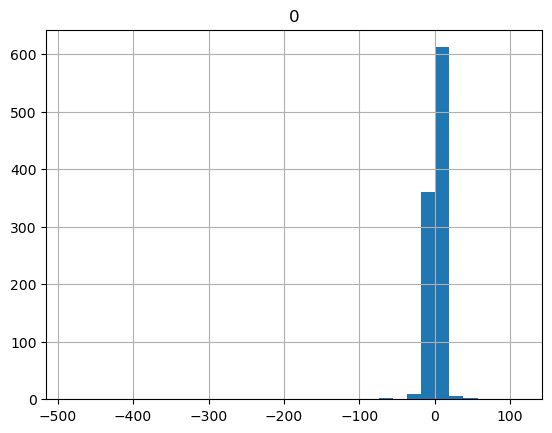

In [92]:
from matplotlib import pyplot as plt

# Non-zero gamma
B = pd.DataFrame([draw_b(100,lambda N: linear_dgp(N,1,1,.01,1,1))[1] for i in range(1000)])

B.hist(bins=int(np.ceil(np.sqrt(B.shape[0]))))

(2) Calculate a region A over which one might fail to reject (i.e, "Accept") the null hypothesis that $b(\gamma{}) = b(0)$ at a conventional level of significance. Discuss.


In [102]:
def linear_dgp(N, beta, gamma, sigma_u, sigma_v):
    iid = np.random.default_rng(1234)
    u = iid.normal(scale=sigma_u, size=N)
    v = iid.normal(scale=sigma_v, size=N)
    Z = iid.normal(size=N)
    pi = np.array([[1], [0.5]])

    X = Z.dot(pi.T) + v.reshape(-1, 1)
    y = X.dot(beta) + Z.dot(gamma) + u

    df = pd.DataFrame({'y': y, 'x': X.squeeze(), 'z': Z, 'Constant': 1})

    return df[['y']], df[['Constant', 'x']], df[['Constant', 'z']]

In [103]:
import scipy.stats as stats

b_gamma_vals = []
se_b_gamma_vals = []

for gamma in gamma_vals:
    y, X, Z = linear_dgp(1000, 2, gamma, [[1, 0.5], [0.5, 1]], 1, 1)
    b = np.linalg.solve(Z.T @ X, Z.T @ y)
    b_gamma = b[1] * gamma
    se_b_gamma = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * np.sum(Z**2)))
    b_gamma_vals.append(b_gamma)
    se_b_gamma_vals.append(se_b_gamma)

TypeError: linear_dgp() takes 5 positional arguments but 6 were given

In [99]:
t_stat = stats.t.ppf(0.975, 1000-3) # two-tailed test
CI_lower = [b - t_stat * se for b, se in zip(b_gamma_vals, se_b_gamma_vals)]
CI_upper = [b + t_stat * se for b, se in zip(b_gamma_vals, se_b_gamma_vals)]

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

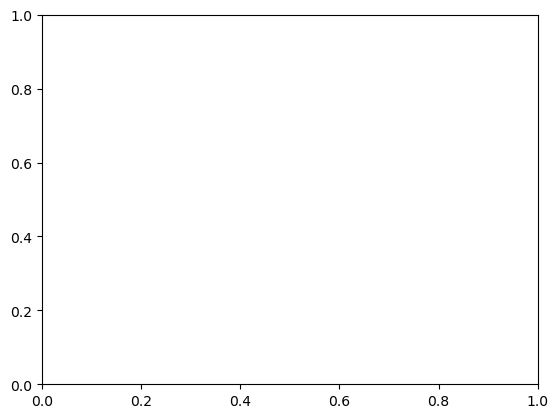

In [100]:
import matplotlib.pyplot as plt

plt.plot(gamma_vals, b_gamma_vals)
plt.fill_between(gamma_vals, CI_lower, CI_upper, alpha=0.2)
plt.axhline(y=0, linestyle='--', color='grey')
plt.xlabel('Gamma')
plt.ylabel('Coefficient on Gamma')
plt.title('95% Confidence Intervals for Coefficient on Gamma')
plt.show()

(3) Further modify the framework so that the covariance of Z and X is equal to a parameter $\sigma{_X}{_Z})$. Calculate the set B of pairs $(\gamma{}, \sigma{_X}{_Z})$ such that one would fail to reject the same null hypothesis at the same level of significance. Discuss.

In [106]:
def linear_dgp(N, beta, gamma, pi, sigma_u, sigma_v, sigma_XZ):
    iid = np.random.default_rng(12345)
    u = iid.normal(scale=sigma_u, size=N)
    v = iid.normal(scale=sigma_v, size=N)
    Z = iid.normal(size=N)
    X = (pi + sigma_XZ * Z).T @ iid.normal(size=(2, N)).T + v.reshape(-1, 1)
    y = (beta + gamma * X[:, 1]) * X[:, 0] + u
    df = pd.DataFrame({'y': y, 'x': X[:, 0], 'z': Z, 'Constant': 1})
    return y, X, Z, df

gamma_vals = np.linspace(0, 2, 21)
sigma_XZ_vals = np.linspace(0, 1, 11)
alpha = 0.05
reject_null = np.zeros((len(gamma_vals), len(sigma_XZ_vals)))

for i, gamma in enumerate(gamma_vals):
    for j, sigma_XZ in enumerate(sigma_XZ_vals):
        y, X, Z, _ = linear_dgp(1000, 2, gamma, [[1, 0.5], [0.5, 1]], 1, 1, sigma_XZ)
        b = np.linalg.solve(Z.T @ X, Z.T @ y)
        b_gamma = b[1] * gamma
        se_b_gamma = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * np.sum(Z**2)))
        t_stat = b_gamma / se_b_gamma[1]
        p_value = 2 * (1 - stats.norm.cdf(np.abs(t_stat)))
        reject_null[i, j] = (p_value < alpha)


ValueError: operands could not be broadcast together with shapes (2,2) (1000,) 

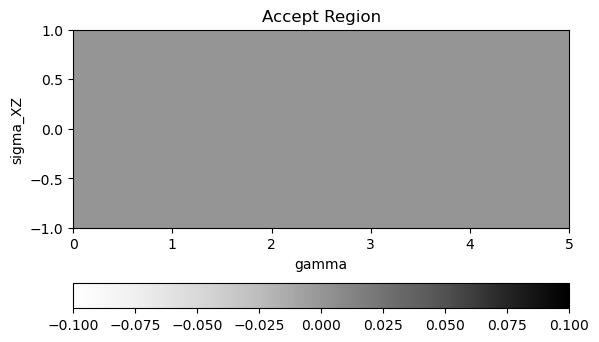

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(accept_region.T, extent=[0, 5, -1, 1], origin='lower', cmap='Greys')
ax.set_xlabel('gamma')
ax.set_ylabel('sigma_XZ')
ax.set_title('Accept Region')
plt.colorbar(im, ax=ax, orientation='horizontal')
plt.show()